# Previsão da Balança Comercial do Brasil

Previsão da Balança Comercial de exportação e importação do comércio exterior (Comex) no Brasil.

Faz-se uso da biblioteca [Prophet](https://facebook.github.io/prophet/) para analisar os dados do Comex dos últimos anos - limpos e tratados por [outro notebook](https://colab.research.google.com/drive/1WRSAEERIYsReXWyuLLLTs28WkV41tFyW) do Google Colab - e gerar previsões do comportamento da balança comercial do comércio exterior.

## Previsões ou Tendências da Balança Comercial nos próximos anos

A simulação de tendências da Balança Comercial foi realizada com os modelos de [Suavização Exponencial Holt-Winters](https://en.wikipedia.org/wiki/Exponential_smoothing) e o método probabilístico de [Monte Carlo](https://pt.wikipedia.org/wiki/M%C3%A9todo_de_Monte_Carlo) com intervalo de confiança de 95%.

Foi utilizado o modelo de Holt-Winter com intuito de aplicar uma Suavização Exponencial nos dados históricos. As vantagens observadas foram sua capacidade de

- Suaviza dados com tendência e sazonalidade, melhorando a visualização de padrões ao longo do tempo
- Reduz o impacto de variações bruscas, tornando os dados mais estáveis e fáceis de interpretar.
- É simples de aplicar e ajusta-se dinamicamente à evolução da série temporal.

Para a análise das tendências do comércio exterior nos próximos anos, foi utilizado modelo de Monte Carlo através da biblioteca Prophet configurado para um intervalo de confiança de 95%. A Prophet realiza simulações aplicando esse modelo sobre os dados históricos. Assim, foi possível simular o comportamento do comércio exterior nos próximos anos. Esse modelo foi escolhido pelas seguintes vantagens:

- Ele se baseia em amostragens aleatórias massivas para obter resultados numéricos
- Permite avaliar a distribuição provável dos resultados futuros, e não apenas um único valor previsto
- Auxilia na avaliação de riscos e na tomada de decisão com base em simulações probabilísticas


## Campos Resultantes da Previsão

Aqui está a lista completa dos campos gerados pelo Prophet, com suas descrições:

### Principais Campos de Previsão
- **`ds`**: Datas da série temporal (passado + futuro previsto)
- **`y`**: Valores reais observados da série temporal (dados históricos brutos), neste caso o valor agregado (da exportação, da importação, ou da balança comercial)
- **`yhat`**: Valor previsto (tendência + sazonalidade + feriados)
- **`yhat_lower`**: Limite inferior do intervalo de confiança
- **`yhat_upper`**: Limite superior do intervalo de confiança

### Componentes de Tendência
- **`trend`**: Valor da tendência principal
- **`trend_lower`**: Limite inferior da tendência
- **`trend_upper`**: Limite superior da tendência

### Componentes Aditivos
- **`additive_terms`**: Soma de todos os efeitos aditivos (sazonalidade + feriados)
- **`additive_terms_lower`**: Limite inferior dos termos aditivos
- **`additive_terms_upper`**: Limite superior dos termos aditivos

### Sazonalidade Anual
- **`yearly`**: Componente sazonal anual
- **`yearly_lower`**: Limite inferior da sazonalidade anual
- **`yearly_upper`**: Limite superior da sazonalidade anual

### Componentes Multiplicativos
- **`multiplicative_terms`**: Soma dos efeitos multiplicativos
- **`multiplicative_terms_lower`**: Limite inferior dos termos multiplicativos
- **`multiplicative_terms_upper`**: Limite superior dos termos multiplicativos

### Observações Importantes:
1. Os intervalos de confiança (`_lower` e `_upper`) usam 95% como padrão
2. Campos como `weekly` ou `holidays` aparecem apenas quando ativados no modelo
3. Para modelos aditivos, `multiplicative_terms` será zero
4. A previsão final (`yhat`) é a soma de todos os componentes relevantes

---

### Parâmetros e Bibliotecas

In [ ]:
# Instala dependências
!python -m pip install prophet pandas matplotlib statsmodels numpy

In [2]:
ano_inicial = int(input("Digite o ano inicial (ex: 2019): "))
ano_final =  int(input("Digite o ano final (ex: 2025): "))

Digite o ano inicial (ex: 2019): 2014
Digite o ano final (ex: 2025): 2024


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

def get_current_period():
  """Get current period"""
  from datetime import datetime
  ano_final = datetime.now().year - 1
  ano_inicial = ano_final - 10
  return (ano_inicial, ano_final)


# ano_final = ano_inicial = ""
if not ano_final or not ano_inicial:
  ano_inicial, ano_final = get_current_period()
FILENAME_EXP = f"dados_comex_EXP_{ano_inicial}_{ano_final}.csv"
FILENAME_IMP = f"dados_comex_IMP_{ano_inicial}_{ano_final}.csv"


INTERVAL_WIDTH=0.95 # intervalo de confiança
FORECAST_PERIODS = 36 # meses no futuro


print("Filename exportação: " + FILENAME_EXP)
print("Filename importação: " + FILENAME_IMP)

Filename exportação: dados_comex_EXP_2014_2024.csv
Filename importação: dados_comex_IMP_2014_2024.csv


## Leitura dos Dados

### Opção 1: Processar os dados originais do Comex

É necessário antes fazer a leitura e limpeza dos dados do Comex. Isso já é feito por [outro notebook](https://colab.research.google.com/drive/1WRSAEERIYsReXWyuLLLTs28WkV41tFyW) e pode ser executado abaixo. Ele irá gerar arquivos na conta logada do Google Drive. Esses arquivos serão utilizados aqui para fazer a Previsão do comércio exterior nos próximos anos.

Caso já tenha feito isso e os arquivos CSV estiverem na localização correta em seu Google Drive, você pode pular esta etapa.
Se ainda não tiver esses arquivos, execute o script abaixo para fazer automaticamente.

Caso contrário, busque uma xícara de chá, respire fundo e relaxe. ☕ Os dados estão cozinhando em fogo baixo - vai demorar mais um pouquinho.


In [4]:
# Carrega Google Drive
from google.colab import drive

DRIVER_PATH = '/content/drive'
BASE_PATH = "MyDrive/comex_data"

# Mount G.Drive
drive.mount(DRIVER_PATH)

print("Drive base path: " + DRIVER_PATH)
print("Drive target: " + BASE_PATH)

Mounted at /content/drive
Drive base path: /content/drive
Drive target: MyDrive/comex_data


In [ ]:
# Baixe o notebook com o tratamento dos dados do Comex
!wget https://raw.githubusercontent.com/Bug-Busters-F/alfalog/refs/heads/feat/notebooks/tratamento-dados/Tratamento%20dos%20Dados%20de%20Exporta%C3%A7%C3%A3o%20e%20Importa%C3%A7%C3%A3o%20dos%20Estados%20Brasileiros.ipynb

# Instale nbconvert se necessário
!pip install nbformat nbconvert

# Execute o notebook baixado
output = !jupyter nbconvert --to notebook --execute  --inplace --stdout "Tratamento dos Dados de Exportação e Importação dos Estados Brasileiros.ipynb" 2>&1
print("\n".join(output))

In [35]:
# Lê CSVs
FILE_PATH_EXP = DRIVER_PATH+"/"+BASE_PATH+"/"+FILENAME_EXP
FILE_PATH_IMP = DRIVER_PATH+"/"+BASE_PATH+"/"+FILENAME_IMP

def read_csv(tipo: str, filepath: str) -> pd.DataFrame:
  """Read CSV from Drive and return DataFrame"""
  print(f"Reading {tipo} CSV from: {filepath}")
  return pd.read_csv(filepath)

df_exp_raw = read_csv("EXP", FILE_PATH_EXP)
df_imp_raw = read_csv("IMP", FILE_PATH_IMP)

Reading EXP CSV from: /content/drive/MyDrive/comex_data/dados_comex_EXP_2014_2024.csv
Reading IMP CSV from: /content/drive/MyDrive/comex_data/dados_comex_IMP_2014_2024.csv


### Opção 2: Carregar CSV com os dados do Comex processados do seu Computador

Se você já executou o notebook mencionado anteriormente e já tem os dados limpos e pré-processados, você pode carregá-lo aqui para gerar a previsão.


#### IMPORTANTE:

Execute o código abaixo para ver os exatos nomes que o arquivo deve ter.

In [10]:
FILENAME_EXP = input("Digite o nome do arquivo CSV de EXPORTAÇÕES (ex: dados_exportacoes.csv): ")
FILENAME_IMP = input("Digite o nome do arquivo CSV de IMPORTAÇÕES (ex: dados_importacoes.csv): ")

Digite o nome do arquivo CSV de EXPORTAÇÕES (ex: dados_exportacoes.csv): dados_comex_EXP_2014_2024.csv
Digite o nome do arquivo CSV de IMPORTAÇÕES (ex: dados_importacoes.csv): dados_comex_IMP_2014_2024.csv


In [ ]:
from google.colab import files
import pandas as pd
import io

def upload_files():
  uploaded = files.upload()
  print("Arquivos carregados:", list(uploaded.keys()))
  return uploaded

uploaded = upload_files()

df_exp_raw = pd.read_csv(io.BytesIO(uploaded[FILENAME_EXP]), encoding='utf-8')
df_imp_raw = pd.read_csv(io.BytesIO(uploaded[FILENAME_IMP]), encoding='utf-8')

print(df_exp_raw.head())

## Previsão ou Tendências da Balança Comercial nos próximos anos

A simulação de tendências da Balança Comercial foi feita com o modelo Prophet.

O Prophet realiza simulações de Monte Carlo e está configurado para um **intervalo de confiança de 95%**. 95% foi o intervalo de confiança adotado para simular o comportamento futuro do comércio exterior, mas o intervalo de confiança ideal depende da finalidade da previsão e da tolerância a riscos.

### DataFrames dos dados

In [38]:

print("\nExportação: ")
df_exp_raw.head()


Exportação: 


,ANO,CO_MES,NO_NCM_POR,NO_PAIS,SG_UF,NO_UF,NO_VIA,NO_URF,KG_LIQUIDO,CO_UNID,VL_FOB
0,2014,3,"Partes para assentos, de outras matérias",França,PR,Paraná,MARITIMA,0917800 - PORTO DE PARANAGUA,6,10,80
1,2014,3,Partes de caixas de marchas,Áustria,SP,São Paulo,MARITIMA,0817800 - PORTO DE SANTOS,3714,11,267395
2,2014,3,"Outras arruelas de ferro fundido, ferro ou aço",Chile,SP,São Paulo,AEREA,0817600 - AEROPORTO INTERNACIONAL DE SAO PAULO...,11,10,2901
3,2014,3,"Armações e cabos, de ferramentas, de escovas e...",Uruguai,RS,Rio Grande do Sul,RODOVIARIA,1010252 - JAGUARAO,16,11,94
4,2014,3,"Outros sacos, bolsas e cartuchos, de outros pl...",Equador,PR,Paraná,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,243,10,5553


In [39]:

print("\nImportação: ")
df_imp_raw.head()


Importação: 


,ANO,CO_MES,NO_NCM_POR,NO_PAIS,SG_UF,NO_UF,NO_VIA,NO_URF,KG_LIQUIDO,CO_UNID,VL_FOB
0,2014,8,"Conectores para circuito impresso, para uma te...",Japão,SP,São Paulo,AEREA,0817700 - AEROPORTO INTERNACIONAL DE VIRACOPOS,820,11,390321
1,2014,7,Volantes e outras polias,China,PR,Paraná,MARITIMA,0817800 - PORTO DE SANTOS,1359,11,27828
2,2014,3,Cartuchos de revelador (toners),Japão,PR,Paraná,AEREA,0915200 - CURITIBA,44,10,5296
3,2014,8,"Outros condensadores fixos, com dielétrico de ...",Japão,SP,São Paulo,AEREA,0817600 - AEROPORTO INTERNACIONAL DE SAO PAULO...,1792,11,186860
4,2014,8,Outras máquinas e aparelhos para soldadura for...,Estados Unidos,MG,Minas Gerais,AEREA,0615100 - IRF/BELO HORIZONTE - MG,3,11,2920


### Prepara os dados para a previsão

In [40]:
def filter_dataframe(df: pd.DataFrame) -> pd.DataFrame:
  """
  Create 'DATA' column as last day of the month,
  compute VALOR_AGREGADO = VL_FOB / KG_LIQUIDO
  and keep only 'DATA' and 'VALOR_AGREGADO'.
  """
  df["VL_FOB"] = pd.to_numeric(df["VL_FOB"], errors="coerce")
  df["KG_LIQUIDO"] = pd.to_numeric(df["KG_LIQUIDO"], errors="coerce")

  # Remove kg <= 0
  df = df[df['KG_LIQUIDO'] > 0].copy()

  # Agrupa por ANO e Mês
  df = df.groupby(['ANO', 'CO_MES']).agg({
      'VL_FOB': 'sum',
      'KG_LIQUIDO': 'sum'
  }).reset_index()

  # Calcula VALOR_AGREGADO
  df['VALOR_AGREGADO'] = df['VL_FOB'] / df['KG_LIQUIDO']

  # Cria campo DATA YYYY-MM-DD
  df["DATA"] = pd.to_datetime(
      df["ANO"].astype(str) + "-" + df["CO_MES"].astype(str).str.zfill(2) + "-01"
  ) + pd.offsets.MonthEnd(0)

  return df[['DATA', 'VL_FOB', 'KG_LIQUIDO', 'VALOR_AGREGADO']]

df_exp = filter_dataframe(df_exp_raw)
df_imp = filter_dataframe(df_imp_raw)


In [41]:
print("Dados de exportação filtrados:")
df_exp.head()


Dados de exportação filtrados:


,DATA,VL_FOB,KG_LIQUIDO,VALOR_AGREGADO
0,2014-01-31,990824691,48624212,20.377188
1,2014-02-28,1028030851,55491196,18.526017
2,2014-03-31,1048746373,55942097,18.746998
3,2014-04-30,1119424298,57881498,19.339933
4,2014-05-31,1123008992,58935445,19.054900


In [42]:
print("Dados de importação filtrados:")
df_imp.head()

Dados de importação filtrados:


,DATA,VL_FOB,KG_LIQUIDO,VALOR_AGREGADO
0,2014-01-31,3111907583,49860087,62.412799
1,2014-02-28,2947144831,46136658,63.878594
2,2014-03-31,3046173209,47212859,64.519990
3,2014-04-30,3074321015,47998613,64.050205
4,2014-05-31,3202448053,48862413,65.540113


### Cria a Balança Comercial

In [43]:
df_balanca = df_exp.copy()
df_balanca['VALOR_AGREGADO'] = df_exp['VALOR_AGREGADO'] - df_imp['VALOR_AGREGADO']
df_balanca = df_balanca.dropna()

df_balanca.head()

,DATA,VL_FOB,KG_LIQUIDO,VALOR_AGREGADO
0,2014-01-31,990824691,48624212,-42.035611
1,2014-02-28,1028030851,55491196,-45.352577
2,2014-03-31,1048746373,55942097,-45.772993
3,2014-04-30,1119424298,57881498,-44.710272
4,2014-05-31,1123008992,58935445,-46.485213


### Suavização Exponencial com Holt-Winters

O modelo de suavização de Holt-Winters é um dos modelos mais apropriado visto que os dados do comércio exterior apresentam comportamento de tendência e sazonalidade.

In [44]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def suavizacao_holt_winter(df):
  df = df.dropna(subset=['VALOR_AGREGADO']).sort_values('DATA')

  # Define a série temporal (índice = data, valores = VALOR_AGREGADO)
  ts = df.set_index('DATA')['VALOR_AGREGADO']
  ts.index = pd.DatetimeIndex(ts.index, freq='ME')

  # Ajusta o modelo Holt-Winters com sazonalidade aditiva
  model = ExponentialSmoothing(
      ts,
      trend='add',           # 'add' para tendência aditiva
      seasonal='add',        # ou 'mul' se a sazonalidade for proporcional
      seasonal_periods=12    # para dados mensais com sazonalidade anual
  ).fit()

  # Suaviza os dados
  df['VALOR_AGREGADO_SUAVIZADO'] = model.fittedvalues.values
  return df

df_exp = suavizacao_holt_winter(df_exp)
df_imp = suavizacao_holt_winter(df_imp)
df_balanca = suavizacao_holt_winter(df_balanca)

df_exp.head()

,DATA,VL_FOB,KG_LIQUIDO,VALOR_AGREGADO,VALOR_AGREGADO_SUAVIZADO
0,2014-01-31,990824691,48624212,20.377188,20.526122
1,2014-02-28,1028030851,55491196,18.526017,17.890957
2,2014-03-31,1048746373,55942097,18.746998,19.593981
3,2014-04-30,1119424298,57881498,19.339933,18.153058
4,2014-05-31,1123008992,58935445,19.054900,20.685299


### Suavização Exponencial Holt-Winters aplicada junto com Suavização Polinomial de Grau 3

Esse modelo suaviza os picos do gráfico permitindo previsões mais estáveis, atenuando variações abruptas.

Uma grande desvantagem desse modelo é reduzir os padrões sazonais. O modelo polinomial reduz o comportamento sazonal dos dados.

In [ ]:
import numpy as np

def suavizacao_polinomial(df, coluna_holt_winters='VALOR_AGREGADO_SUAVIZADO', grau_polinomio=3):
    """
    Adiciona uma coluna com ajuste polinomial aos dados já suavizados.
    Retorna um DataFrame com a nova coluna 'VALOR_POLINOMIAL'.
    """
    # Converte datas para valores numéricos (dias desde a primeira data)
    df = df.copy()
    df['DATA_NUM'] = (df['DATA'] - df['DATA'].min()).dt.days

    # Ajusta o polinômio
    coeficientes = np.polyfit(df['DATA_NUM'], df[coluna_holt_winters], deg=grau_polinomio)
    df['VALOR_POLINOMIAL'] = np.polyval(coeficientes, df['DATA_NUM'])

    # Remove a coluna auxiliar
    df.drop('DATA_NUM', axis=1, inplace=True)

    return df

df_exp_pol = suavizacao_polinomial(df_exp)
df_exp_pol.head()
# df_imp_pol = suavizacao_polinomial(df_imp)
# df_balanca_pol = suavizacao_polinomial(df_balanca)

### Previsão Monte Carlo com Prophet


In [45]:
from prophet import Prophet

def future(df: pd.DataFrame, coluna_valor="VALOR_AGREGADO_SUAVIZADO"):
    df = df.rename(columns={"DATA": "ds", coluna_valor: "y"})

    # Modelo
    m = Prophet(
        interval_width=INTERVAL_WIDTH,
        daily_seasonality=False,
        weekly_seasonality=False,
        yearly_seasonality=True,
        seasonality_mode='additive'
    )

    # Treina o modelo
    model = m.fit(df)
    # Cria datas futuras
    future = m.make_future_dataframe(periods=FORECAST_PERIODS, freq="ME")  # FORECAST_PERIODS meses no futuro
    # Previsão
    forecast = m.predict(future)
    # Mescla o valor agregado na previsão
    forecast = forecast.merge(
      df[['ds', 'y']],   # Seleciona apenas colunas de data e valor real
      on='ds',           # Mescla pelas datas
      how='left'         # Mantém todas as linhas do forecast
    )
    return (m, forecast)


# Forecasting
## Exportacao
# model_exp, forecast_exp = future(df_exp, "VALOR_AGREGADO")
model_exp_suav, forecast_exp_suav = future(df_exp, "VALOR_AGREGADO_SUAVIZADO")
# model_exp_suav_pol, forecast_exp_suav_pol = future(df_exp, "VALOR_POLINOMIAL")

## Importacao
# model_imp, forecast_imp = future(df_imp)
model_imp_suav, forecast_imp_suav = future(df_imp, "VALOR_AGREGADO_SUAVIZADO")

## Balança Comercial
# model_balanca, forecast_balanca = future(df_balanca)
model_balanca_suav, forecast_balanca_suav = future(df_balanca, "VALOR_AGREGADO_SUAVIZADO")


DEBUG:cmdstanpy:input tempfile: /tmp/tmp4fvhs9uf/juvrzgjs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4fvhs9uf/2m98knwy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66800', 'data', 'file=/tmp/tmp4fvhs9uf/juvrzgjs.json', 'init=/tmp/tmp4fvhs9uf/2m98knwy.json', 'output', 'file=/tmp/tmp4fvhs9uf/prophet_modela0zposqz/prophet_model-20250616131628.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:16:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:16:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4fvhs9uf/i8ckb2nq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4fvhs9uf/rh5pwuxy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

In [46]:
forecast_exp_suav.info()
# df_exp.keys()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ds                          168 non-null    datetime64[ns]
 1   trend                       168 non-null    float64       
 2   yhat_lower                  168 non-null    float64       
 3   yhat_upper                  168 non-null    float64       
 4   trend_lower                 168 non-null    float64       
 5   trend_upper                 168 non-null    float64       
 6   additive_terms              168 non-null    float64       
 7   additive_terms_lower        168 non-null    float64       
 8   additive_terms_upper        168 non-null    float64       
 9   yearly                      168 non-null    float64       
 10  yearly_lower                168 non-null    float64       
 11  yearly_upper                168 non-null    float64       

### Plot charts

In [47]:
import matplotlib.pyplot as plt
from prophet.plot import add_changepoints_to_plot

def plot_chart(df, model, forecast, title):
  fig1 = model.plot(forecast)
  fig2 = model.plot_components(forecast)

  # Change axis titles
  ax = fig1.gca()  # get current axes
  ax.set_title(title, fontsize=14)
  ax.set_xlabel("Data", fontsize=12)
  ax.set_ylabel("Valor Agregado (R$/kg)", fontsize=12)

  # Highlight the forecast period
  color = "red"
  xlim = ax.get_xlim()
  forecast_start = forecast[forecast['ds'] > df['DATA'].max()]['ds'].min()
  ax.axvline(x=forecast_start, color=color, linestyle='--', alpha=0.5)
  ax.text(forecast_start, ax.get_ylim()[1]*0.9, ' Previsão', color=color)

  # Adjust y-axis to reasonable range
  current_ylim = ax.get_ylim()
  # ax.set_ylim(current_ylim[0]*1.1, current_ylim[1]*1.1)  # Add 10% padding
  lower = current_ylim[0] - (current_ylim[1] - current_ylim[0]) * 0.05
  upper = current_ylim[1] + (current_ylim[1] - current_ylim[0]) * 0.05
  ax.set_ylim(lower, upper)

  # Add grid for better readability
  ax.grid(True, which='both', linestyle='--', alpha=0.5)

  # Add changepoints
  add_changepoints_to_plot(ax, model, forecast)

  # Add last value annotation
  last_val = forecast.iloc[-1]
  ax.annotate(f"{last_val['yhat']:.1f}",
    xy=(last_val['ds'], last_val['yhat']),
    xytext=(10,10), textcoords='offset points')

  plt.tight_layout()
  plt.show()
  return plt

Tendência Monte Carlo dos dados de Exportação:


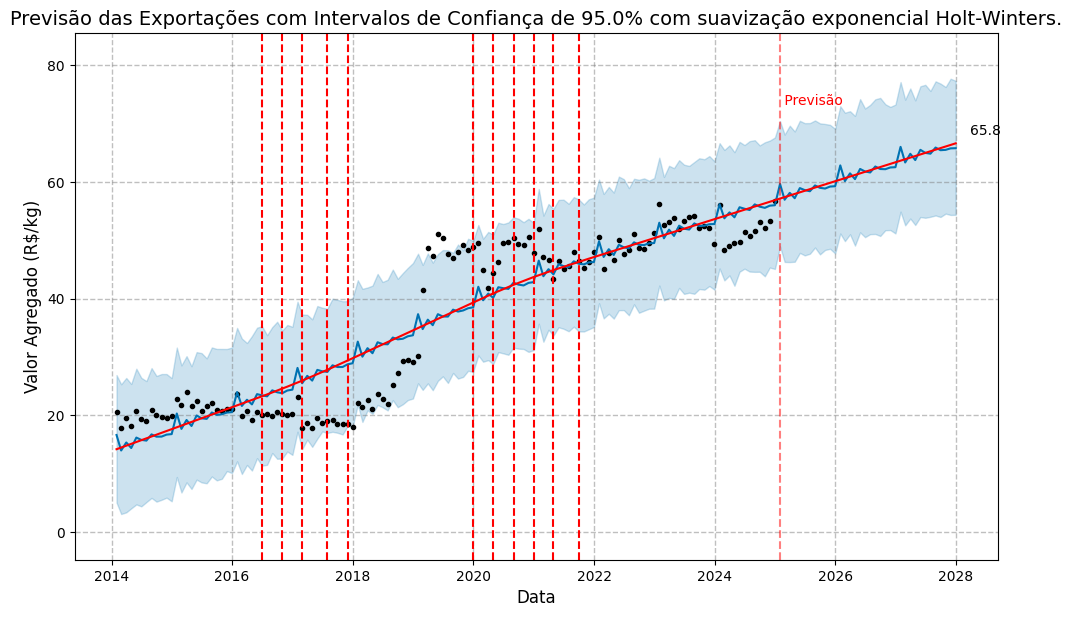

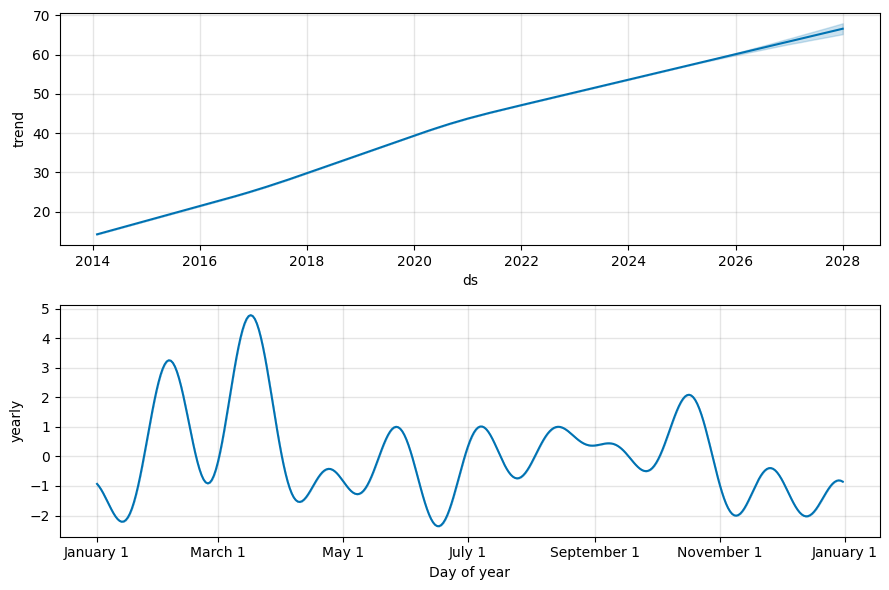

In [48]:
print("Tendência Monte Carlo dos dados de Exportação:")
# plot_exp = plot_chart(df_exp, model_exp, forecast_exp, f"Previsão das Exportações com Intervalos de Confiança de {(INTERVAL_WIDTH * 100)}% sem suavização.")
# print(forecast_exp_suav[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail(15))
plot_exp_suav = plot_chart(df_exp, model_exp_suav, forecast_exp_suav, f"Previsão das Exportações com Intervalos de Confiança de {(INTERVAL_WIDTH * 100)}% com suavização exponencial Holt-Winters.")
# plot_exp_suav_pol = plot_chart(df_exp, model_exp_suav_pol, forecast_exp_suav_pol, f"Previsão das Exportações com Intervalos de Confiança de {(INTERVAL_WIDTH * 100)}% \ncom suavização exponencial Holt-Winters e suavização polinomial de grau 3.")



Tendência Monte Carlo dos dados de Importação:


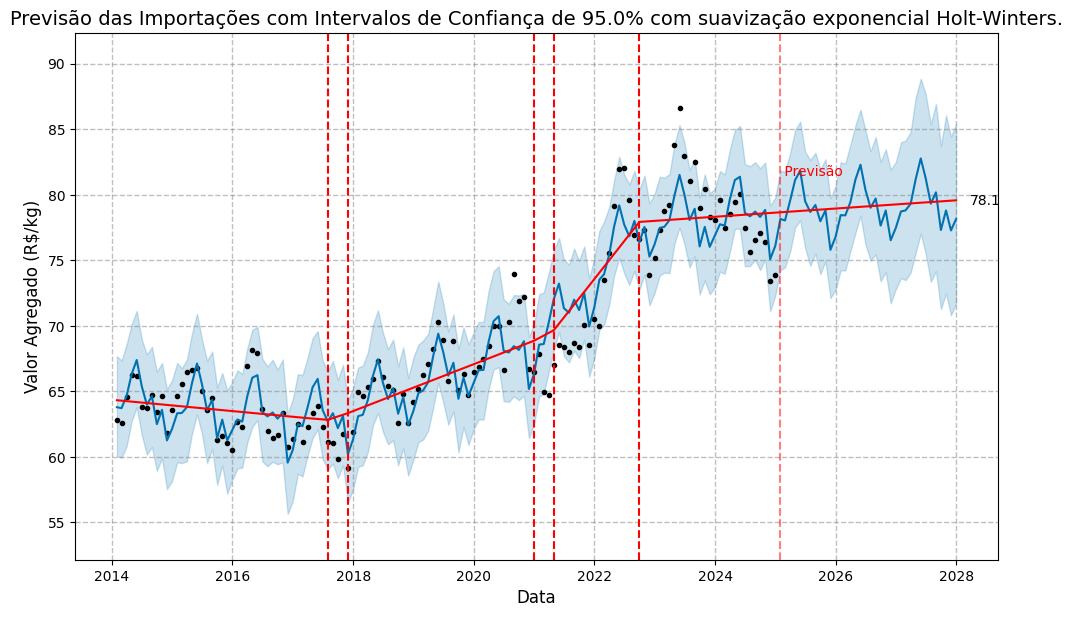

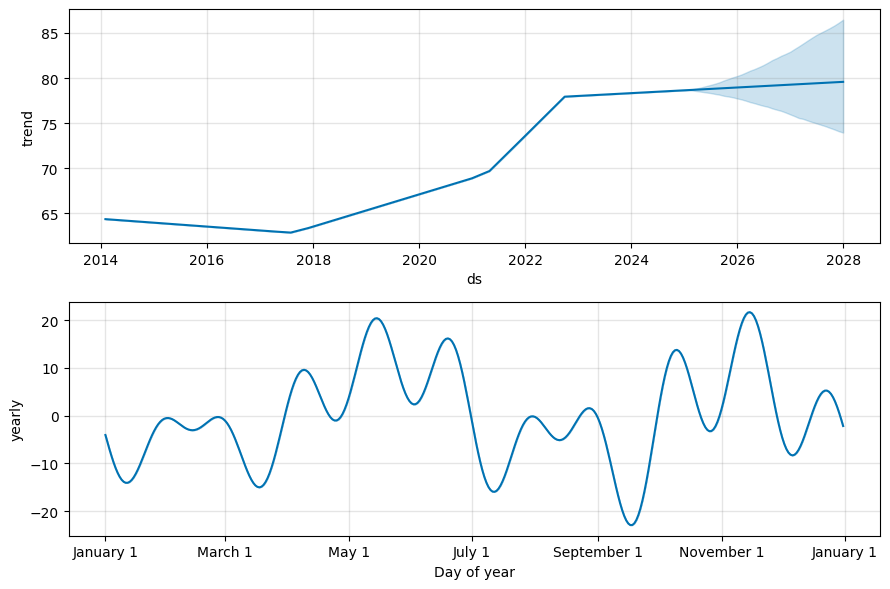

In [49]:
print("Tendência Monte Carlo dos dados de Importação:")
# plot_imp = plot_chart(df_imp, model_imp, forecast_imp, f"Previsão das importações com Intervalos de Confiança de {(INTERVAL_WIDTH * 100)}%")
plot_imp_suav = plot_chart(df_imp, model_imp_suav, forecast_imp_suav, f"Previsão das Importações com Intervalos de Confiança de {(INTERVAL_WIDTH * 100)}% com suavização exponencial Holt-Winters.")
# print(forecast_imp[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail(15))

Tendência Monte Carlo da Balança Comercial:


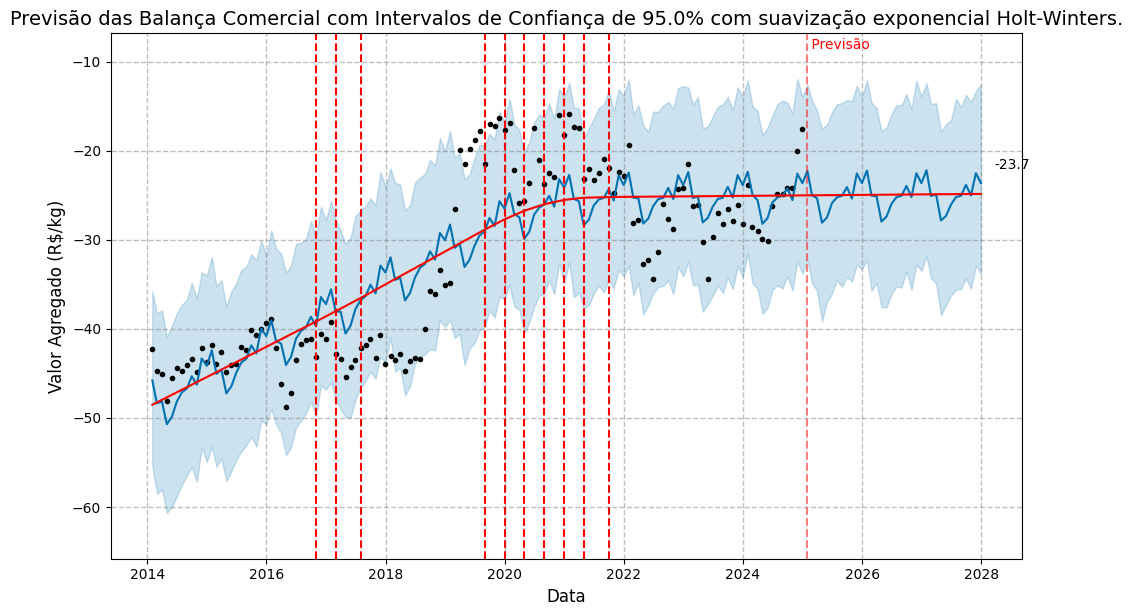

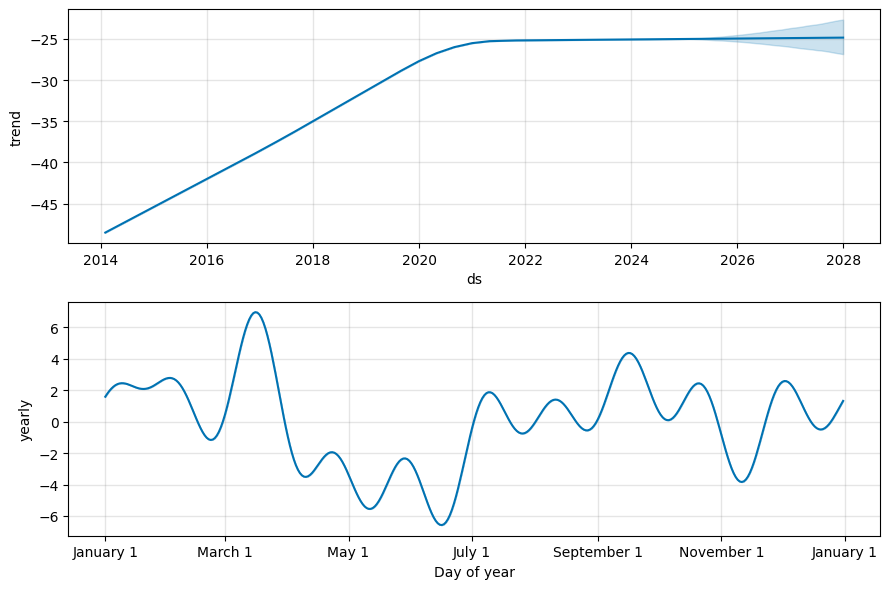

In [50]:
print("Tendência Monte Carlo da Balança Comercial:")
# plot_balanca = plot_chart(df_balanca, model_balanca, forecast_balanca, f"Previsão da Balança Comercial com Intervalos de Confiança de {(INTERVAL_WIDTH * 100)}%")
plot_balanca_suav = plot_chart(df_balanca, model_balanca_suav, forecast_balanca_suav, f"Previsão das Balança Comercial com Intervalos de Confiança de {(INTERVAL_WIDTH * 100)}% com suavização exponencial Holt-Winters.")
# print(forecast_balanca[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail(15))

## Download dos dados em CSV

In [51]:
def download(df, filename):
  df.to_csv(
      filename,
      index=False,
      encoding='utf-8'
  )

  # Download automático
  from google.colab import files
  files.download(filename)

### Exportações

In [52]:
download(forecast_exp_suav, 'exportacao_forecast_prophet_suavizado.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Importações

In [53]:
download(forecast_imp_suav, 'importacao_forecast_prophet_suavizado.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Balança Comercial

In [54]:
download(forecast_balanca_suav, 'balanca_forecast_prophet_suavizado.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>